# Understanding Tennis Player Movements Through Pose Detection

## Importing Required Libraries

* **cv2** (OpenCV) for image manipulation.

* **numpy** for handling arrays.

* **cv2_imshow** from **google.colab.patches** to display images in Google Colab.

In [1]:
import cv2 as cv
import numpy as np
from google.colab.patches import cv2_imshow

## Loading the COCO Model (OpenPose)

* **pose_deploy_linevec.prototxt:** Defines the model architecture.

* **pose_iter_440000.caffemodel:** Contains the trained weights for the model.

We also set the input dimensions (**inWidth** and **inHeight**) for the image blob and define a **threshold** value for detecting poses.

In [2]:
# Load COCO model (OpenPose)
protoFile = "/content/pose_deploy_linevec.prototxt"
weightsFile = "/content/pose_iter_440000.caffemodel"

net = cv.dnn.readNetFromCaffe(protoFile, weightsFile)

   # Set input dimensions for blob
inWidth = 368
inHeight = 368
threshold = 0.1

## Defining COCO Body Keypoints and Pose Pairs



Defines the body keypoints and the corresponding pose pairs for the COCO dataset:

* **BODY_PARTS:** A dictionary mapping human body parts to their respective keypoint IDs.

* **POSE_PAIRS:** A list of pairs of body parts that are connected to represent the skeleton structure of the human body.

These keypoints and pairs are used to detect and visualize human poses in images.

In [3]:
# COCO body keypoints
BODY_PARTS = {
    "Nose": 0, "Neck": 1,
    "RShoulder": 2, "RElbow": 3, "RWrist": 4,
    "LShoulder": 5, "LElbow": 6, "LWrist": 7,
    "RHip": 8, "RKnee": 9, "RAnkle": 10,
    "LHip": 11, "LKnee": 12, "LAnkle": 13,
    "REye": 14, "LEye": 15,
    "REar": 16, "LEar": 17,
    "Background": 18
}

POSE_PAIRS = [
    ["Neck", "RShoulder"], ["Neck", "LShoulder"],
    ["RShoulder", "RElbow"], ["RElbow", "RWrist"],
    ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
    ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"],
    ["Neck", "LHip"], ["LHip", "LKnee"], ["LKnee", "LAnkle"],
    ["Neck", "Nose"], ["Nose", "REye"], ["REye", "REar"],
    ["Nose", "LEye"], ["LEye", "LEar"]
]


## Loading and Processing the Input ImageI
In this step, we load the input image and prepare it for processing by the neural network. The image is resized and normalized into a blob that can be fed into the model. We then perform a forward pass through the OpenPose network to generate the output, which contains the predicted human pose keypoints. This output will be used to visualize the detected body parts and joints.



In [4]:
image = cv.imread("/content/images/input1.jpg")
frameHeight, frameWidth = image.shape[:2]

# Prepare blob
inpBlob = cv.dnn.blobFromImage(image, 1.0 / 255, (inWidth, inHeight),
                               (0, 0, 0), swapRB=False, crop=False)

# Set the input to the network
net.setInput(inpBlob)
output = net.forward()


## Detecting and Visualizing Keypoints

In this section, the model's output is processed to extract the detected body keypoints. For each body part, we find the position with the highest confidence (probability), scale it to the image dimensions, and store the coordinates. If the confidence score exceeds a certain threshold, a circle is drawn at that position, and the body part ID is displayed. The keypoints are stored in a list for further use.

In [5]:
H, W = output.shape[2], output.shape[3]

# Store detected keypoints
points = []

for i in range(len(BODY_PARTS)):
    # Confidence map of corresponding body's part.
    probMap = output[0, i, :, :]
    minVal, prob, minLoc, point = cv.minMaxLoc(probMap)

    x = int((frameWidth * point[0]) / W)
    y = int((frameHeight * point[1]) / H)

    if prob > threshold:
        cv.circle(image, (x, y), 5, (0, 255, 255), thickness=-1, lineType=cv.FILLED)
        cv.putText(image, f"{i}", (x, y), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
        points.append((x, y))
    else:
        points.append(None)


## Draw Skeleton Connections
In this step, we use the detected keypoints to draw the human pose skeleton. For each defined pair of body parts, a line is drawn connecting the corresponding keypoints. Additionally, circles are drawn at each keypoint to highlight the detected body joints. This visualization helps in understanding the pose and spatial relationships between different body parts.



In [6]:
for pair in POSE_PAIRS:
    partFrom = pair[0]
    partTo = pair[1]
    idFrom = BODY_PARTS[partFrom]
    idTo = BODY_PARTS[partTo]

    if points[idFrom] and points[idTo]:
        cv.line(image, points[idFrom], points[idTo], (255, 0, 0), 3)
        cv.ellipse(image, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
        cv.ellipse(image, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)


## Displaying the Final Result
In this final step, the processed image with the detected pose skeleton is displayed using cv2_imshow(). The function waits for a key press to close the display window, and then cv.destroyAllWindows() is called to clean up any open windows. This allows the user to visually inspect the pose estimation results.



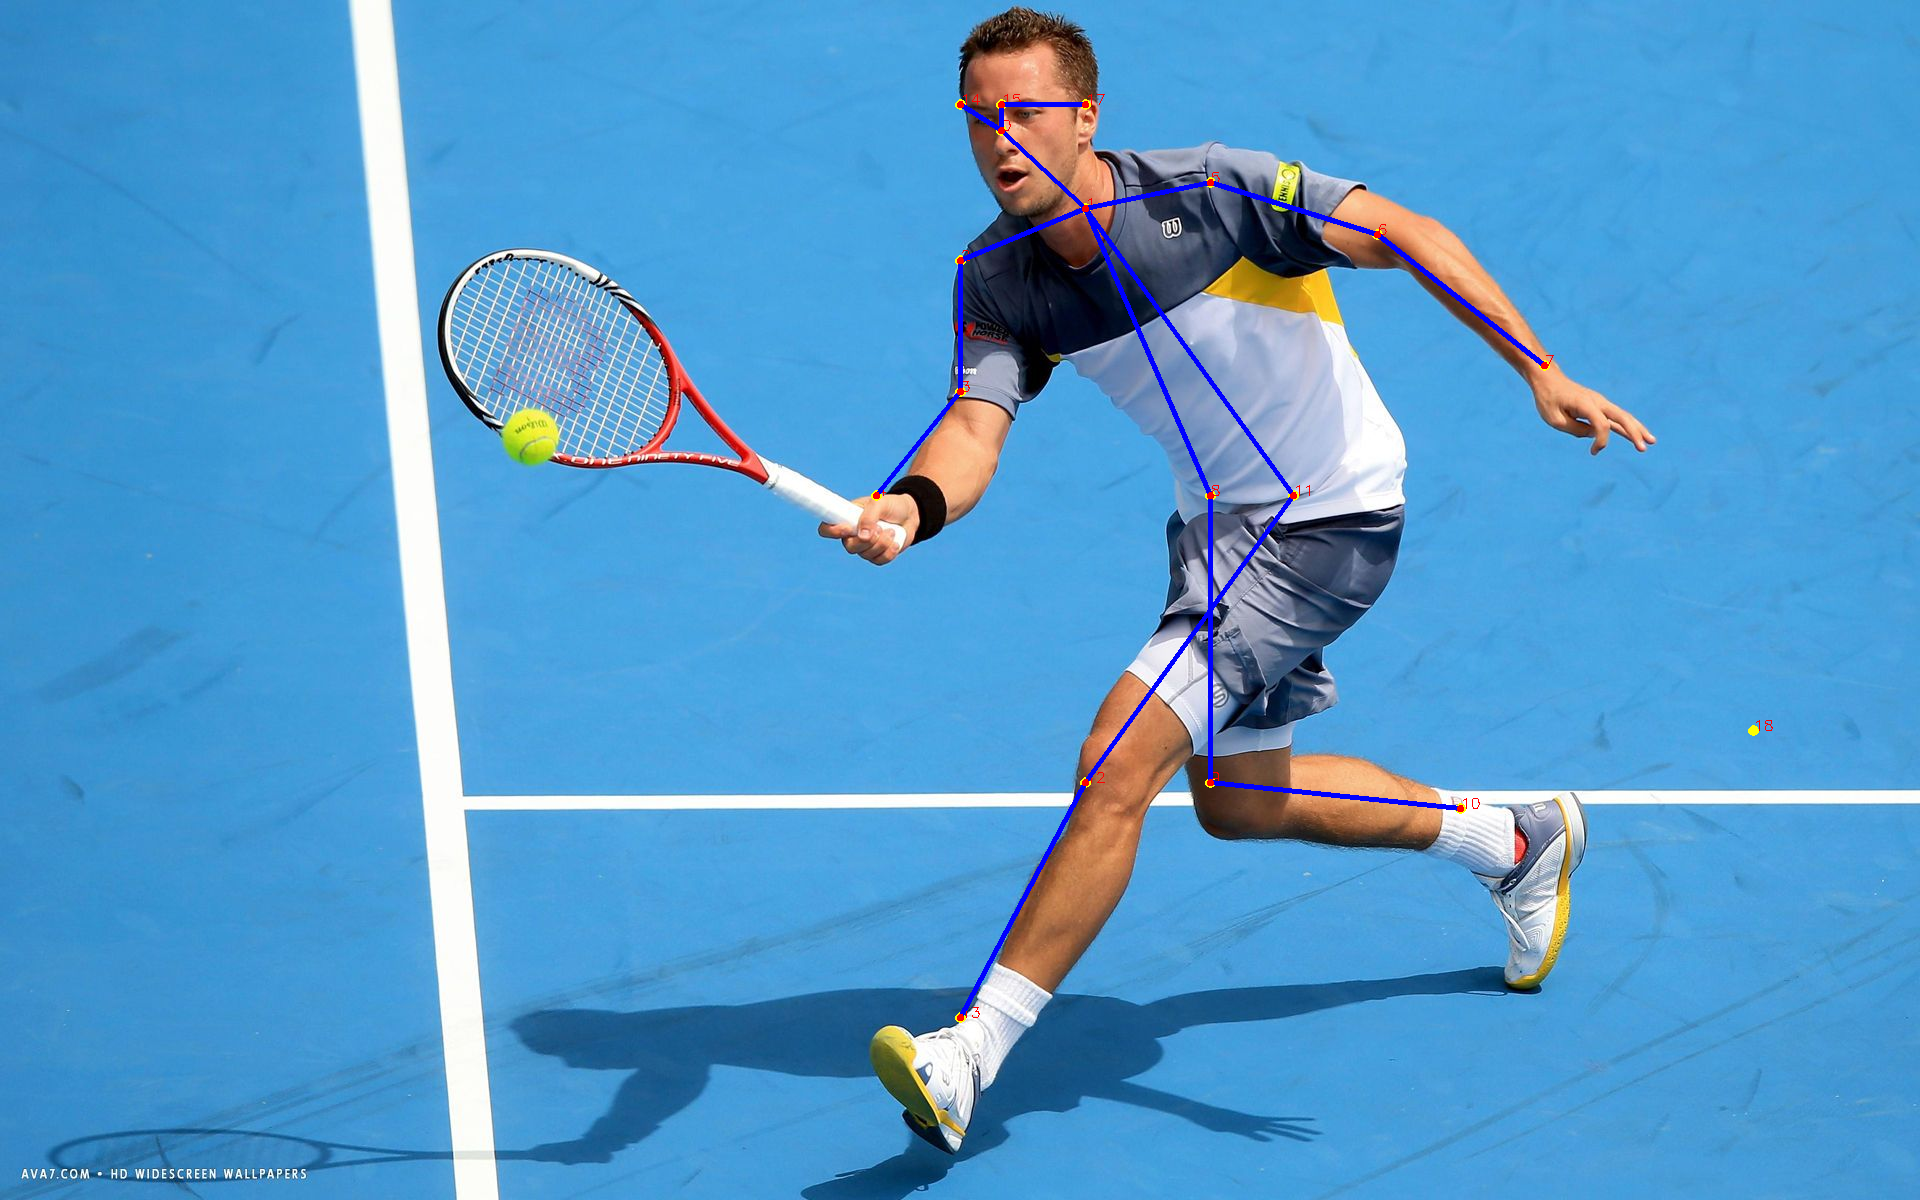

In [7]:
cv2_imshow(image)
cv.waitKey(0)
cv.destroyAllWindows()


## Render Pose Skeleton on Blank Canvas
In this step, a blank image (canvas) is created with the same dimensions as the original image. The pose skeleton is then drawn on this blank canvas by connecting the detected keypoints, similar to the previous step. This allows for an alternative visualization where only the pose structure is shown, without the original image. Finally, the pose skeleton is displayed on the blank canvas for easier analysis.

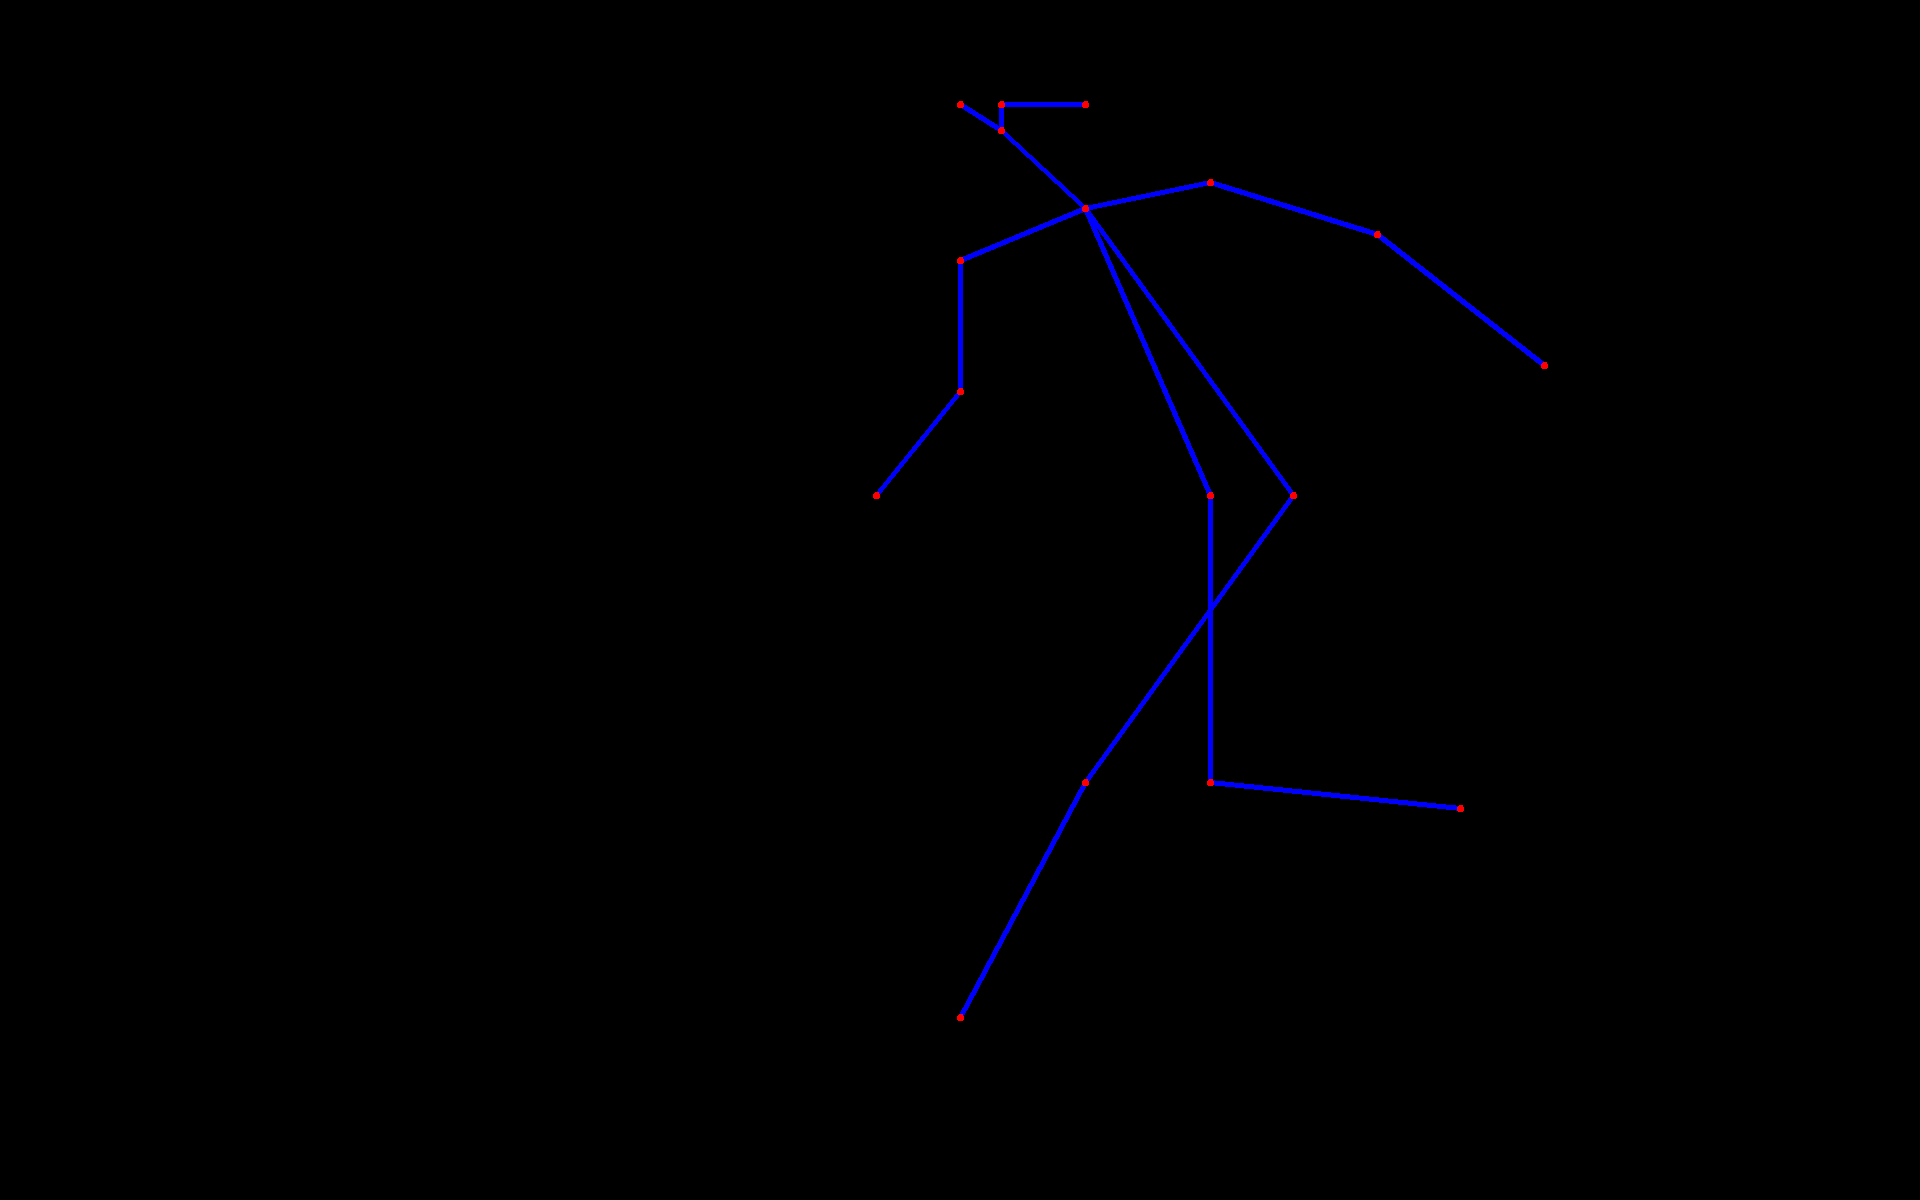

In [8]:
# Create a blank canvas (same size as original image)
blank_image = np.zeros_like(image)

# Draw pose skeleton on the blank image
for pair in POSE_PAIRS:
    partFrom = pair[0]
    partTo = pair[1]
    idFrom = BODY_PARTS[partFrom]
    idTo = BODY_PARTS[partTo]

    # Only draw if both points are detected
    if points[idFrom] and points[idTo]:
        cv.line(blank_image, points[idFrom], points[idTo], (255, 0, 0), thickness=3)
        cv.ellipse(blank_image, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), thickness=cv.FILLED)
        cv.ellipse(blank_image, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), thickness=cv.FILLED)

# Show the blank image with the skeleton overlay
cv2_imshow(blank_image)


## Defining a Function to Calculate Angles Between Body Joints

In this section, a function calculate_angle() is defined to compute the angle between three keypoints (body joints). The function takes three points (a, b, c) as input, calculates the vectors between them, and then computes the angle between these vectors using the dot product and arccosine formula. This function is useful for analyzing the orientation of body parts, such as the angle between the shoulder, elbow, and wrist. If any of the points are missing, it returns None.

In [9]:
import math
import numpy as np
import cv2 as cv

def calculate_angle(a, b, c):
    if a is None or b is None or c is None:
        return None
    a, b, c = np.array(a), np.array(b), np.array(c)
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc) + 1e-6)
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    return np.degrees(angle)

## Calculating and Displaying Joint Angles
In this step, we define a set of joint triplets for which we want to calculate the angles. These triplets represent key points in the body, such as the shoulder, elbow, and wrist. The calculate_angle() function is used to compute the angle between these points. The angles are then displayed on the image at appropriate positions, ensuring that the text doesn't overlap with other elements. This allows for a detailed analysis of body angles, such as the angle between the shoulder and elbow or the hip angle.

In [12]:
angle_triplets = [
    ("RShoulder", "RElbow", "RWrist"),
    ("LShoulder", "LElbow", "LWrist"),
    ("RHip", "RKnee", "RAnkle"),
    ("LHip", "LKnee", "LAnkle"),
    ("Neck", "RShoulder", "RElbow"),
    ("Neck", "LShoulder", "LElbow"),
    ("RShoulder", "Neck", "LShoulder"),
    ("RHip", "Neck", "LHip"),
]

def adjust_text_position(base_point, offset=(10, -10)):
    return (base_point[0] + offset[0], base_point[1] + offset[1])

used_positions = set()
for a_name, b_name, c_name in angle_triplets:
    a = points[BODY_PARTS[a_name]]
    b = points[BODY_PARTS[b_name]]
    c = points[BODY_PARTS[c_name]]

    angle = calculate_angle(a, b, c)
    if angle is not None:
        # Print to console
        print(f"Angle between {a_name}-{b_name}-{c_name}: {int(angle)}{chr(176)}")

        # Text on image
        angle_text = f"{int(angle)}deg"
        text_position = b
        offset = (10, -10)
        new_position = adjust_text_position(text_position, offset)

        while new_position in used_positions:
            offset = (offset[0], offset[1] - 10)
            new_position = adjust_text_position(text_position, offset)

        used_positions.add(new_position)

        cv.putText(image, angle_text, new_position, cv.FONT_HERSHEY_COMPLEX, 0.9, (0, 255, 0), 2)

Angle between RShoulder-RElbow-RWrist: 141°
Angle between LShoulder-LElbow-LWrist: 159°
Angle between RHip-RKnee-RAnkle: 95°
Angle between LHip-LKnee-LAnkle: 172°
Angle between Neck-RShoulder-RElbow: 112°
Angle between Neck-LShoulder-LElbow: 150°
Angle between RShoulder-Neck-LShoulder: 169°
Angle between RHip-Neck-LHip: 12°


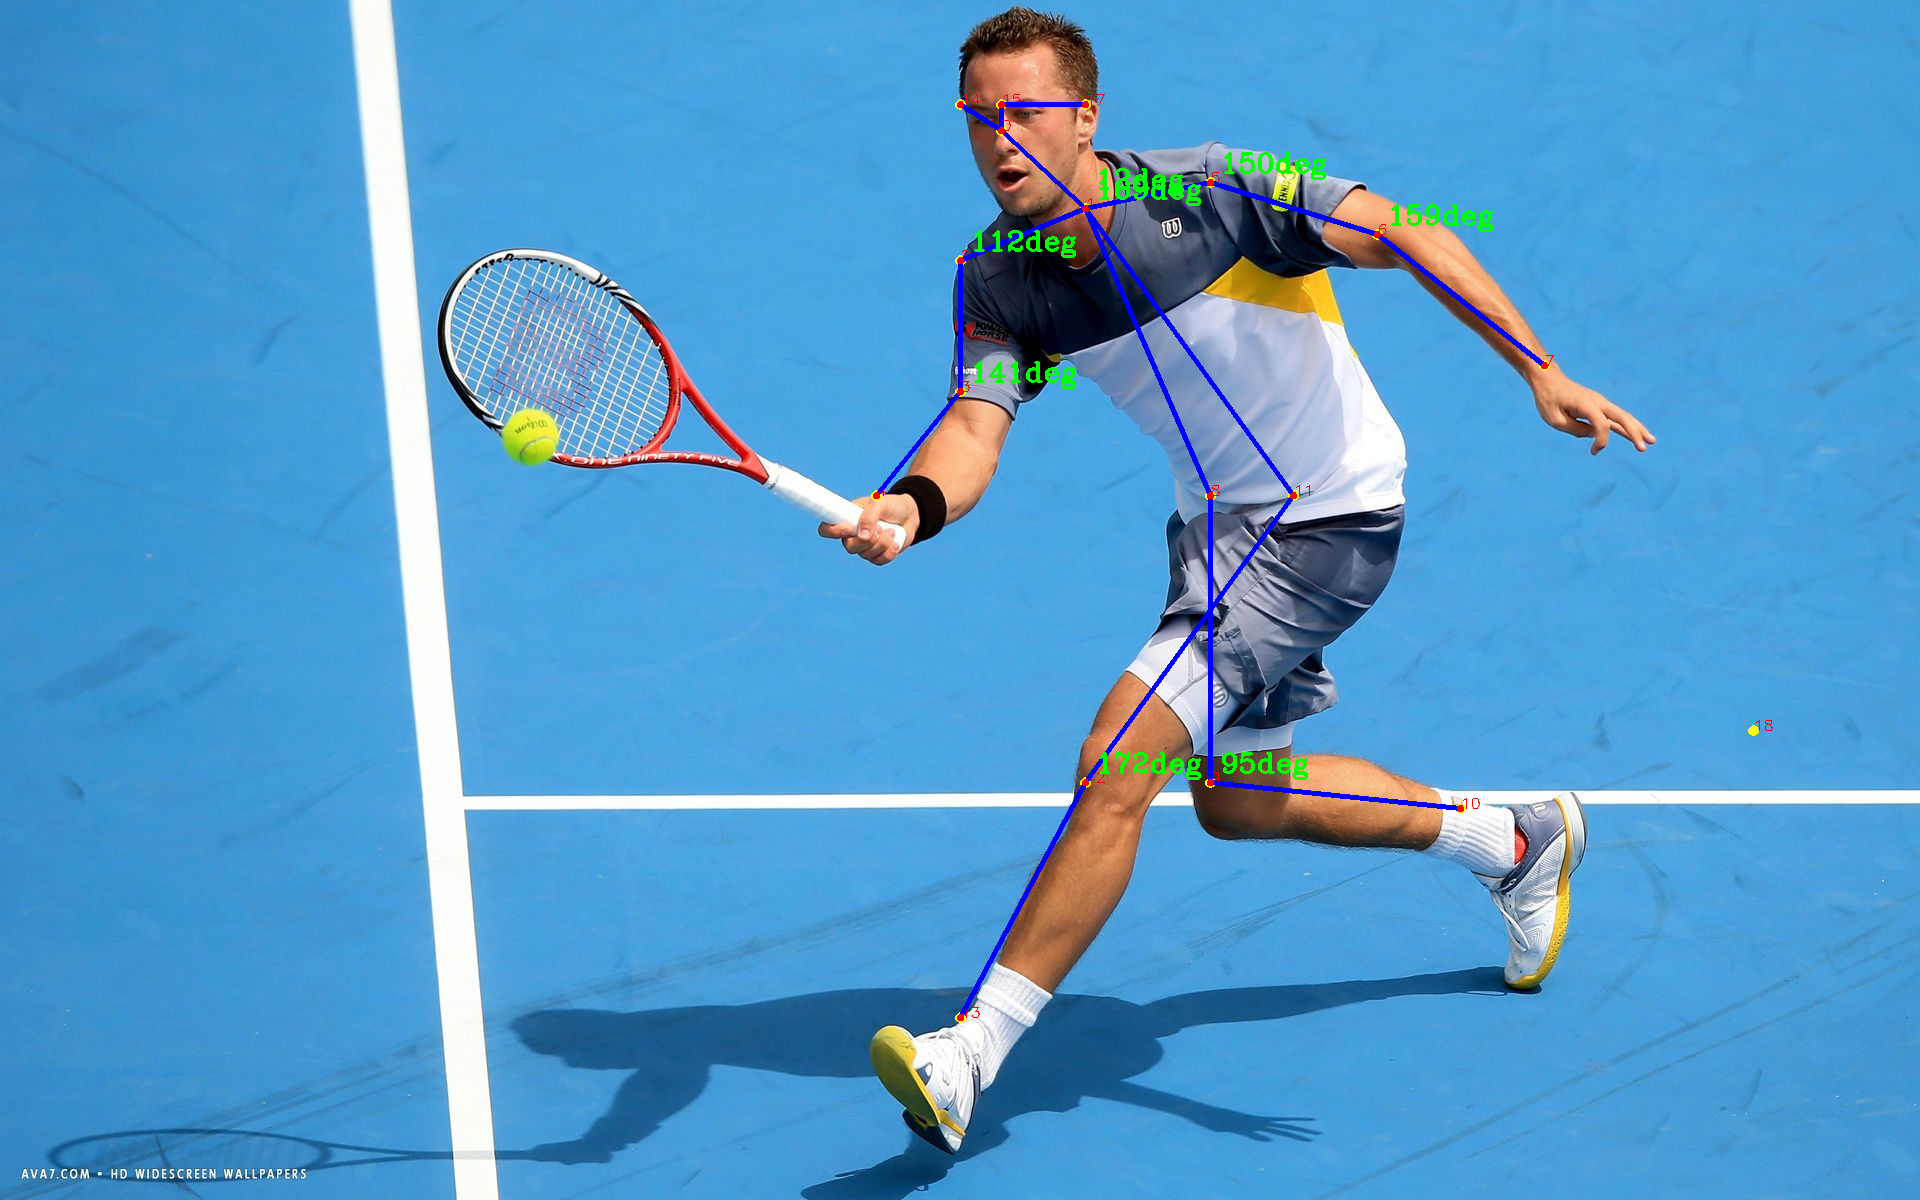

In [13]:
cv2_imshow(image)